<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [104]:
# Cargamos las librerías a utilizar
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from gower import gower_matrix

In [26]:
# Cargamos y visualizamos los datos
datos = pd.read_csv('datos_clientes.csv')
datos.head()

,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto
0,1,Mujer,41,98115.05,39
1,2,Mujer,20,35458.14,75
2,3,Mujer,68,59872.08,55
3,4,Hombre,63,48508.93,51
4,5,Mujer,31,44431.11,54


Para la carga de datos, se descarga la base de los clientes y se llama a este notebook mediante la libreria de pandas, visualizando los primeros 5 datos y creando un dataframe llamado 'datos'.

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [27]:
# Información general del DataFrame
print("\nInformación general del DataFrame:")
print(datos.info())


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id_Cliente     200 non-null    int64  
 1   Genero         200 non-null    object 
 2   Edad           200 non-null    int64  
 3   Ingreso        200 non-null    float64
 4   Puntaje_Gasto  200 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 7.9+ KB
None


In [28]:
# Estadísticas descriptivas variables numéricas
print("\nEstadísticas descriptivas de las variables numéricas:")
print(datos.describe())


Estadísticas descriptivas de las variables numéricas:
       Id_Cliente        Edad        Ingreso  Puntaje_Gasto
count  200.000000  200.000000     200.000000     200.000000
mean   100.500000   38.850000   60624.446600      50.200000
std     57.879185   13.969007   26262.903416      25.823522
min      1.000000   18.000000   13458.020000       1.000000
25%     50.750000   28.750000   41512.787500      34.750000
50%    100.500000   36.000000   60777.960000      50.000000
75%    150.250000   49.000000   77143.865000      73.000000
max    200.000000   70.000000  138584.520000      99.000000


In [29]:
# Cálculo de estadísticas descriptivas para variables categóricas
print("\nDistribución de género:")
print(datos['Genero'].value_counts())


Distribución de género:
Genero
Mujer     112
Hombre     88
Name: count, dtype: int64


En este análisis inicial se muestra que el conjunto de datos consta de 200 observaciones y cinco variables: `Id_Cliente`, `Genero`, `Edad`, `Ingreso` y `Puntaje_Gasto`, sin valores nulos. La distribución de género es un poco mayor para las mujeres que son 112 en comparación con los hombres que son 88; las estadísticas descriptivas nos muestran que la edad promedio de los clientes es de aproximadamente 39 años, con ingresos anuales en promedio de 60,624  y un puntaje de gasto promedio de 50; el rango de edad de los clientes varía de 18 a 70 años, mientras que los ingresos anuales fluctúan significativamente, desde aproximadamente 13,458 hasta 138,585; para el gasto, este varía de 1 a 99.

In [30]:
# Agrupación de edades en categorías etarias
bins = [18, 24, 34, 44, 54, 64, np.inf]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
datos['Grupo_Etario'] = pd.cut(datos['Edad'], bins=bins, labels=labels)

# Descripción por grupo etario
print("\nDistribución de grupos etarios:")
print(datos['Grupo_Etario'].value_counts())


Distribución de grupos etarios:
Grupo_Etario
25-34    54
35-44    42
45-54    39
18-24    31
55-64    16
65+      14
Name: count, dtype: int64


In [31]:
# Agrupar por Género y Grupo Etario y calcular estadísticas descriptivas
stats = datos.groupby(['Genero', 'Grupo_Etario']).agg({
    'Ingreso': ['mean', 'std', 'min', 'max'],
    'Puntaje_Gasto': ['mean', 'std', 'min', 'max']
}).reset_index()

# Mostrar estadísticas descriptivas
print(stats)

    Genero Grupo_Etario       Ingreso                                     \
                                 mean           std       min        max   
0   Hombre        18-24  46628.876154  23406.995166  13458.02   80360.65   
1   Hombre        25-34  78927.434545  32734.446993  22531.85  138584.52   
2   Hombre        35-44  67001.986111  22499.533107  18797.16   91426.18   
3   Hombre        45-54  58029.127143  20522.769162  24993.78   97525.80   
4   Hombre        55-64  55780.227778  25094.510046  18434.74   94049.49   
5   Hombre          65+  51366.806667  14577.260971  18437.21   64156.37   
6    Mujer        18-24  41380.962222  19665.459732  15766.84   71427.64   
7    Mujer        25-34  65815.380000  23049.652497  19003.52  103654.79   
8    Mujer        35-44  66923.430000  31556.048353  19281.75  119534.68   
9    Mujer        45-54  59210.614800  26541.550152  24402.32  126685.78   
10   Mujer        55-64  57098.777143  20204.546850  19617.67   80565.01   
11   Mujer  

C:\Users\dshar\AppData\Local\Temp\ipykernel_5776\272448222.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = datos.groupby(['Genero', 'Grupo_Etario']).agg({


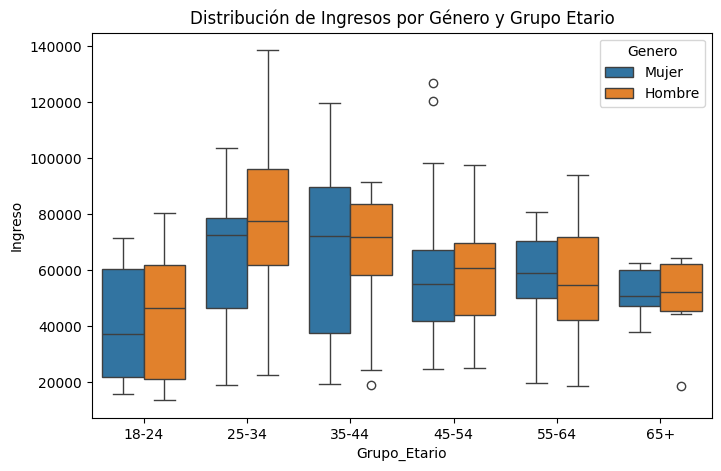

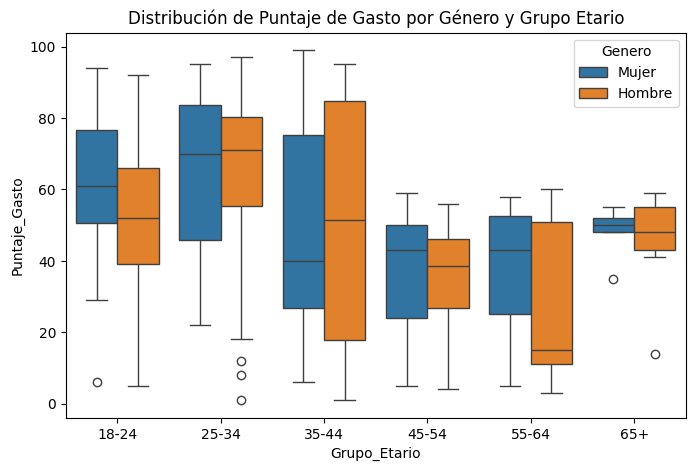

In [32]:
# Visualización de Ingresos por Género y Grupo Etario
plt.figure(figsize=(8, 5))
sns.boxplot(x='Grupo_Etario', y='Ingreso', hue='Genero', data=datos)
plt.title('Distribución de Ingresos por Género y Grupo Etario')
plt.show()

# Visualización de Puntaje de Gasto por Género y Grupo Etario
plt.figure(figsize=(8, 5))
sns.boxplot(x='Grupo_Etario', y='Puntaje_Gasto', hue='Genero', data=datos)
plt.title('Distribución de Puntaje de Gasto por Género y Grupo Etario')
plt.show()


Se puede ver en el anterior análisis y respectivos graficos por grupos etarios que: 

Los hombres en el grupo etario de 25-34 años presentan los ingresos promedio más altos (78,927), mientras que las mujeres en el mismo grupo tienen ingresos significativamente menores (65,815), en general, los ingresos tienden a ser más altos en los grupos etarios más jóvenes y disminuyen a medida que aumenta la edad, con algunas variaciones notables entre géneros. 

En cuanto a los puntajes de gasto, las mujeres en los grupos etarios de 18-24 y 25-34 años tienen puntajes más altos, lo que sugiere una mayor frecuencia de compra o mayor gasto en comparación con los hombres de las mismas edades, mientras que los hombres de 25-34 años también muestran un alto puntaje de gasto, lo que indica patrones de compra activos en estos grupos demográficos, aunque en los grupos etarios más avanzados, los puntajes de gasto disminuyen para ambos géneros, reflejando posiblemente una reducción en la actividad de compra con la edad.

In [40]:
#Diferencias en ingresos por género
hombres = datos[datos['Genero'] == 'Hombre']['Ingreso']
mujeres = datos[datos['Genero'] == 'Mujer']['Ingreso']
t_stat, p_value = stats.ttest_ind(hombres, mujeres)
print(f"\nPrueba t para diferencias de ingresos entre hombres y mujeres: t-stat={t_stat:.3f}, p-value={p_value:.3f}")


Prueba t para diferencias de ingresos entre hombres y mujeres: t-stat=0.716, p-value=0.475


In [41]:
#Diferencias en puntajes de gastos por género
puntaje_hombres = datos[datos['Genero'] == 'Hombre']['Puntaje_Gasto']
puntaje_mujeres = datos[datos['Genero'] == 'Mujer']['Puntaje_Gasto']
t_stat, p_value = stats.ttest_ind(puntaje_hombres, puntaje_mujeres)
print(f"\nPrueba t para diferencias de puntajes de gastos entre hombres y mujeres: t-stat={t_stat:.3f}, p-value={p_value:.3f}")


Prueba t para diferencias de puntajes de gastos entre hombres y mujeres: t-stat=-0.819, p-value=0.414


In [54]:
# prueba ANOVA solo si todos los grupos tienen suficiente datos y variabilidad
grupos_validos = [datos[datos['Grupo_Etario'] == grupo]['Ingreso'] for grupo in datos['Grupo_Etario'].unique() if len(datos[datos['Grupo_Etario'] == grupo]['Ingreso']) > 1 and datos[datos['Grupo_Etario'] == grupo]['Ingreso'].std() > 0]

if len(grupos_validos) > 1:
    anova_result = stats.f_oneway(*grupos_validos)
    print(f"\nANOVA para diferencias de ingresos por grupos etarios: F-stat={anova_result.statistic:.3f}, p-value={anova_result.pvalue:.3f}")


ANOVA para diferencias de ingresos por grupos etarios: F-stat=5.884, p-value=0.000


In [56]:
# Prueba ANOVA solo si todos los grupos tienen suficientes datos y variabilidad en Puntaje_Gasto
grupos_validos_gastos = [datos[datos['Grupo_Etario'] == grupo]['Puntaje_Gasto'] for grupo in datos['Grupo_Etario'].unique() if len(datos[datos['Grupo_Etario'] == grupo]['Puntaje_Gasto']) > 1 and datos[datos['Grupo_Etario'] == grupo]['Puntaje_Gasto'].std() > 0]

if len(grupos_validos_gastos) > 1:
    anova_result_gastos = stats.f_oneway(*grupos_validos_gastos)
    print(f"\nANOVA para diferencias de puntajes de gastos por grupos etarios: F-stat={anova_result_gastos.statistic:.3f}, p-value={anova_result_gastos.pvalue:.3f}")


ANOVA para diferencias de puntajes de gastos por grupos etarios: F-stat=8.092, p-value=0.000


El análisis muestra que, aunque no hay diferencias significativas en ingresos y puntajes de gastos entre hombres y mujeres, sí existen diferencias significativas por grupos etarios tanto en ingresos como en puntajes de gastos. Esto sugiere que la segmentación basada en la edad podría ser más efectiva que la segmentación por género para estrategias de marketing focalizadas en esta tienda. Las diferencias significativas en los ingresos y los comportamientos de gasto según la edad pueden guiar estrategias de personalización de productos, promociones y campañas para los diferentes grupos etarios.

In [50]:
# 3.5 Diferencias en puntajes de gastos por grupos etarios y género
for grupo in labels:
    grupo_data = datos[datos['Grupo_Etario'] == grupo]
    hombres = grupo_data[grupo_data['Genero'] == 'Hombre']['Puntaje_Gasto']
    mujeres = grupo_data[grupo_data['Genero'] == 'Mujer']['Puntaje_Gasto']
    
    if len(hombres) > 0 and len(mujeres) > 0:
        t_stat, p_value = stats.ttest_ind(hombres, mujeres)
        print(f"\nPrueba t grupo etario {grupo} entre hombres y mujeres: t-stat={t_stat:.3f}, p-value={p_value:.3f}")


Prueba t grupo etario 18-24 entre hombres y mujeres: t-stat=-1.269, p-value=0.214

Prueba t grupo etario 25-34 entre hombres y mujeres: t-stat=-0.177, p-value=0.860

Prueba t grupo etario 35-44 entre hombres y mujeres: t-stat=0.244, p-value=0.809

Prueba t grupo etario 45-54 entre hombres y mujeres: t-stat=-0.533, p-value=0.597

Prueba t grupo etario 55-64 entre hombres y mujeres: t-stat=-0.797, p-value=0.439

Prueba t grupo etario 65+ entre hombres y mujeres: t-stat=-0.303, p-value=0.767


In [53]:
# Diferencias en ingresos por grupos etarios y género
for grupo in labels:
    grupo_data = datos[datos['Grupo_Etario'] == grupo]
    ingresos_hombres = grupo_data[grupo_data['Genero'] == 'Hombre']['Ingreso']
    ingresos_mujeres = grupo_data[grupo_data['Genero'] == 'Mujer']['Ingreso']
    
    # Verificar que ambos grupos tengan datos suficientes para realizar la prueba t
    if len(ingresos_hombres) > 0 and len(ingresos_mujeres) > 0:
        # Realizar la prueba t para comparar los ingresos entre hombres y mujeres dentro del mismo grupo etario
        t_stat, p_value = stats.ttest_ind(ingresos_hombres, ingresos_mujeres)
        print(f"\nPrueba t de ingresos para el grupo etario {grupo} entre hombres y mujeres: t-stat={t_stat:.3f}, p-value={p_value:.3f}")



Prueba t de ingresos para el grupo etario 18-24 entre hombres y mujeres: t-stat=0.677, p-value=0.504

Prueba t de ingresos para el grupo etario 25-34 entre hombres y mujeres: t-stat=1.729, p-value=0.090

Prueba t de ingresos para el grupo etario 35-44 entre hombres y mujeres: t-stat=0.009, p-value=0.993

Prueba t de ingresos para el grupo etario 45-54 entre hombres y mujeres: t-stat=-0.144, p-value=0.886

Prueba t de ingresos para el grupo etario 55-64 entre hombres y mujeres: t-stat=-0.113, p-value=0.912

Prueba t de ingresos para el grupo etario 65+ entre hombres y mujeres: t-stat=-0.021, p-value=0.984


En resumen, los resultados indican que no existen diferencias significativas en los ingresos ni en los puntajes de gastos entre hombres y mujeres dentro de cada grupo etario. Esto sugiere que, en esta muestra de clientes, el género no influye significativamente en los ingresos ni en los patrones de gasto cuando se analiza dentro de los mismos grupos de edad. Las estrategias de marketing podrían beneficiarse más de centrarse en otros factores de segmentación, como la edad (grupos etarios), que han demostrado tener diferencias significativas en ingresos y puntajes de gastos en análisis anteriores.

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

In [78]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Seleccionar las columnas de interés
X = datos[['Ingreso', 'Puntaje_Gasto']]

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled[:5])


[[ 1.43109398 -0.43480148]
 [-0.96065004  0.96277471]
 [-0.02871939  0.18634349]
 [-0.46247436  0.03105725]
 [-0.61813319  0.14752193]]


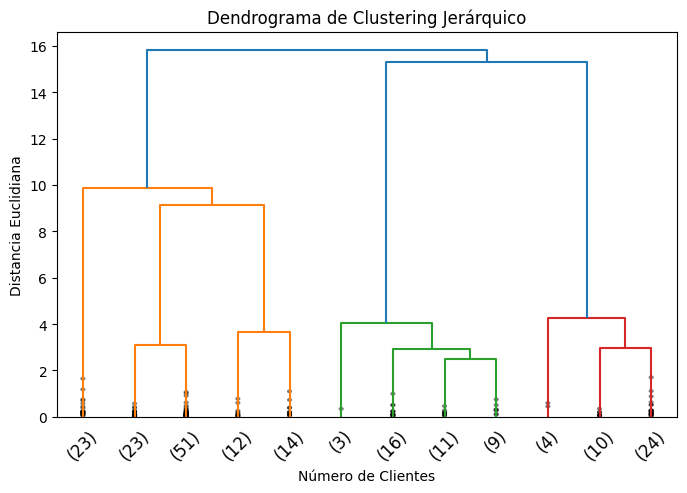

In [80]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Aplicar el clustering jerárquico con el método de enlace 'ward' y distancia euclidiana
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Graficar el dendrograma
plt.figure(figsize=(8, 5))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Número de Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()

Para este procedimiento primero se selecciona únicamente las dos variables de interés (Ingreso y Puntaje_Gasto), luego se hace la estandarización de datos ya que esta es crucial porque Ingreso y Puntaje_Gasto están en diferentes escalas, la estandarización resuelve este problema al transformar los datos para que tengan una media de 0 y una desviación estándar de 1 y así asegurarnos que ambas variables tengan la misma influencia en el cálculo de distancias, y finalmente se construye el Dendrograma con el método de enlace 'ward' y la distancia euclidiana, este método 'ward' minimiza la varianza dentro de los clusters, haciendo que los clusters sean lo más homogéneos posible.

El dendrograma muestra cómo los clientes se agrupan en función de su similitud en términos de ingreso y puntaje de gasto, en la parte inferior del dendrograma, los clientes individuales se combinan en pequeños clusters a distancias bajas, indicando alta similitud. A medida que se asciende, estos pequeños clusters se fusionan en clusters más grandes, hasta que finalmente todos se agrupan en un solo cluster en la parte superior, representando menor similitud. El Cluster Naranja agrupa a clientes con ingresos y puntajes de gasto medianos que se combinan a distancias más bajas, indicando alta similitud interna. El Cluster Verde contiene clientes que son distintos del cluster naranja, pero aún muestran similitud interna, ya que se fusionan a alturas medias. El Cluster Rojo incluye clientes que se unen a alturas más altas, indicando que son significativamente diferentes de los otros grupos, posiblemente debido a ingresos o puntajes de gasto más extremos.

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

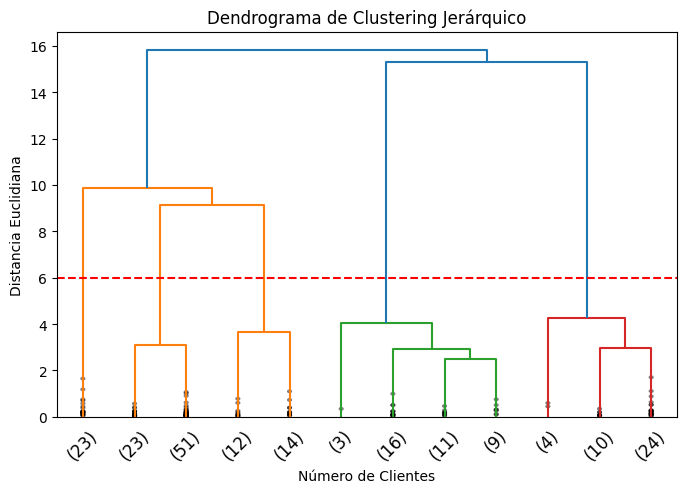

Clusters formados (hasta la distancia 6): 5


In [82]:
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

# Aplicar el clustering jerárquico con el método de enlace 'ward'
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Graficar el dendrograma con una línea horizontal en la distancia 6
plt.figure(figsize=(8, 5))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.axhline(y=6, color='r', linestyle='--')
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Número de Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()

# Obtener los clusters
clusters = fcluster(Z, t=6, criterion='distance')
print(f"Clusters formados (hasta la distancia 6): {len(set(clusters))}")



Observando el dendrograma, podemos contar cuántas ramas principales se forman cuando la línea horizontal corta a la altura de 6, este número será el número de clusters óptimos que en este caso es igual a 5 clusters.

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

In [88]:
from sklearn.cluster import AgglomerativeClustering

# Configuración del modelo de clustering aglomerativo
agglomerative_clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

# Ajuste del modelo
clusters = agglomerative_clustering.fit_predict(X_scaled)

# Añadir resultados de clusters al DataFrame original para análisis
datos['Cluster'] = clusters

# Mostrar algunos datos con los clusters asignados
print(datos.head())



   Id_Cliente  Genero  Edad   Ingreso  Puntaje_Gasto Grupo_Etario  Cluster
0           1   Mujer    41  98115.05             39        35-44        0
1           2   Mujer    20  35458.14             75        18-24        3
2           3   Mujer    68  59872.08             55          65+        4
3           4  Hombre    63  48508.93             51        55-64        4
4           5   Mujer    31  44431.11             54        25-34        4


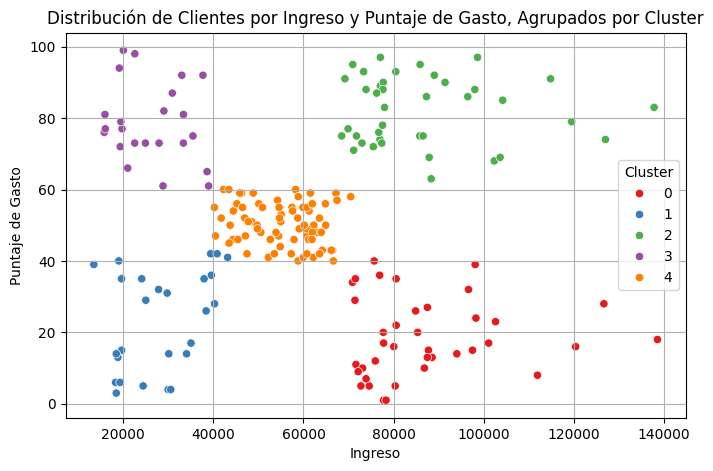

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un gráfico de dispersión de Ingreso vs Puntaje_Gasto, coloreado por cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(data=datos, x='Ingreso', y='Puntaje_Gasto', hue='Cluster', palette='Set1')

# Agregar detalles al gráfico
plt.title('Distribución de Clientes por Ingreso y Puntaje de Gasto, Agrupados por Cluster')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

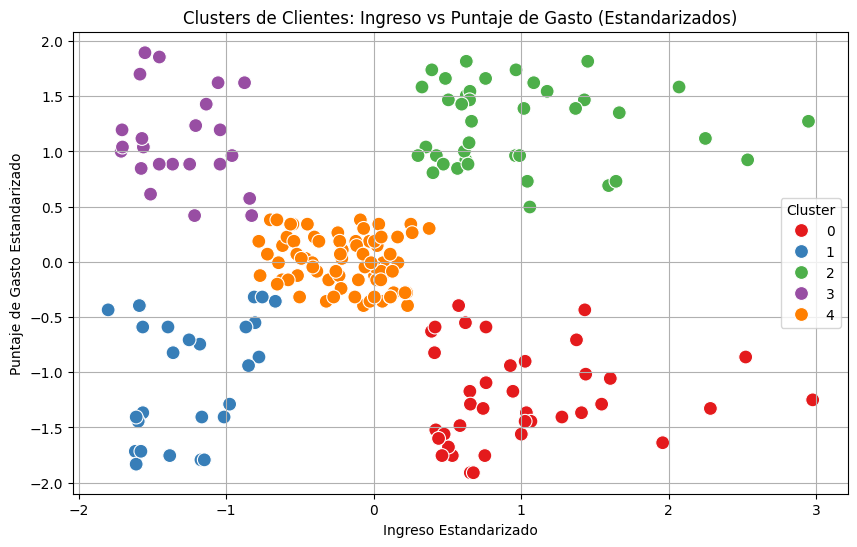

In [90]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos las columnas de Ingreso y Puntaje_Gasto
X = datos[['Ingreso', 'Puntaje_Gasto']]

# Estandarizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Añadimos las columnas estandarizadas al dataframe original para facilitar la visualización
datos['Ingreso_Estandarizado'] = X_scaled[:, 0]
datos['Puntaje_Gasto_Estandarizado'] = X_scaled[:, 1]

# Visualización de los clusters en un gráfico de dispersión estandarizado
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Ingreso_Estandarizado', 
    y='Puntaje_Gasto_Estandarizado', 
    hue='Cluster', 
    data=datos, 
    palette='Set1', 
    s=100
)

# Configuración del gráfico
plt.title('Clusters de Clientes: Ingreso vs Puntaje de Gasto (Estandarizados)')
plt.xlabel('Ingreso Estandarizado')
plt.ylabel('Puntaje de Gasto Estandarizado')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Para este punto se hace la aplicación del algoritmo jerárquico utilizando el método de enlace 'ward' para asignar a cada cliente a uno de los clusters identificados y  y la distancia euclidiana.

Lo que se puede concluir es que una vez formados los clusters, para maximizar los ingresos y la efectividad de las campañas de marketing, la estrategia debería concentrarse principalmente en el Cluster 4 (Naranja), seguido por los Clusters 1 (Morado) y 5 (Rojo), ya que estos grupos representan clientes con alto valor potencial (ingresos) para la tienda, ya que los Clusters 2 (Azul) y 3 (Verde Claro) podrían ser gestionados con estrategias menos intensivas o específicas, dadas sus características de gasto que muestran ser más moderadas.

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

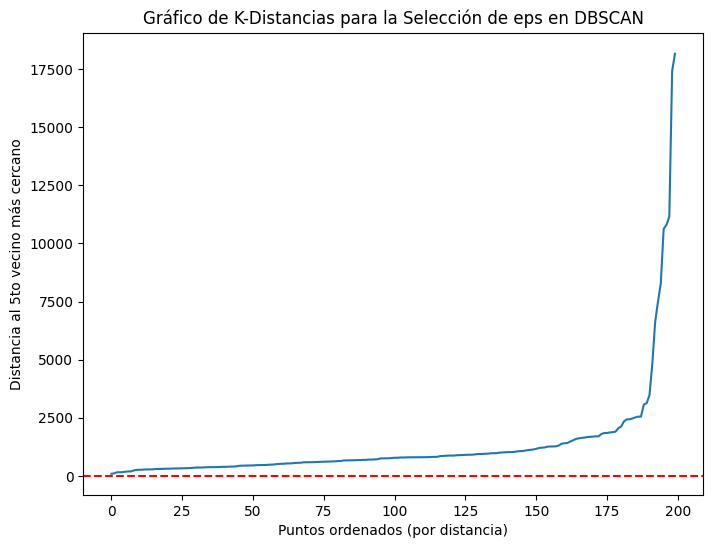

In [91]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Configuración de NearestNeighbors para calcular las distancias al 5to vecino más cercano
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distancias, indices = nbrs.kneighbors(X)

# Ordenar las distancias de los 5 vecinos más cercanos
distancias = np.sort(distancias[:, 4], axis=0)

# Graficar las distancias ordenadas
plt.figure(figsize=(8, 6))
plt.plot(distancias)
plt.axhline(y=0.5, color='r', linestyle='--')  # Línea roja indicando el "codo" de la curva
plt.xlabel("Puntos ordenados (por distancia)")
plt.ylabel("Distancia al 5to vecino más cercano")
plt.title("Gráfico de K-Distancias para la Selección de eps en DBSCAN")
plt.show()

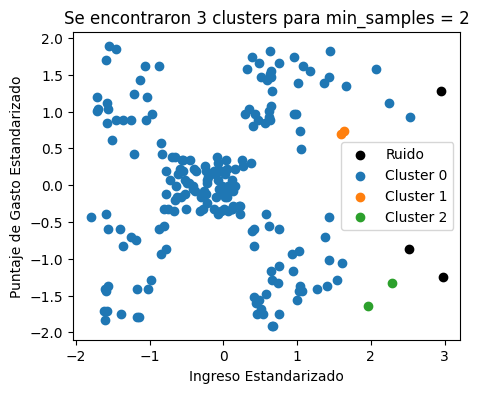

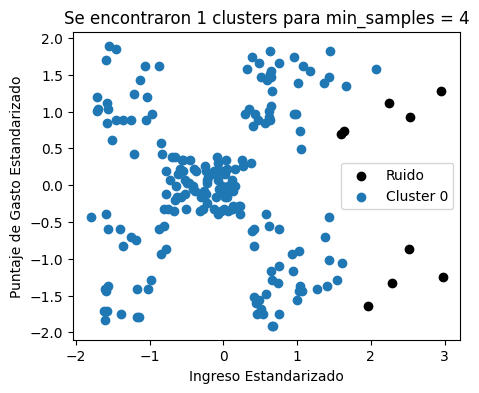

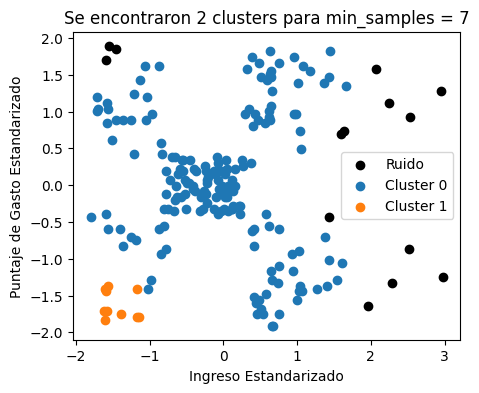

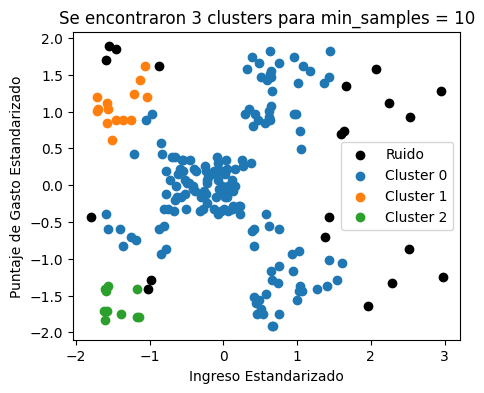

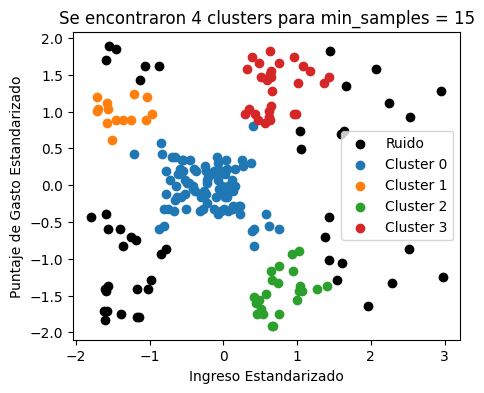

In [98]:
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Estandarización de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(datos[['Ingreso', 'Puntaje_Gasto']])

eps_value = 0.5 
min_samples_values = [2, 4, 7, 10, 15]  

for minpts in min_samples_values:
    db = DBSCAN(eps=eps_value, min_samples=minpts).fit(X_scaled)
    cluster_labels = db.labels_
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

    plt.figure(figsize=(5, 4))
    for k in np.unique(cluster_labels):
        if k == -1:
            # Puntos clasificados como ruido
            plt.scatter(X_scaled[cluster_labels == k, 0], X_scaled[cluster_labels == k, 1], color='black', label='Ruido')
        else:
            plt.scatter(X_scaled[cluster_labels == k, 0], X_scaled[cluster_labels == k, 1], label=f'Cluster {k}')
    plt.title(f'Se encontraron {n_clusters} clusters para min_samples = {minpts}')
    plt.legend()
    plt.xlabel('Ingreso Estandarizado')
    plt.ylabel('Puntaje de Gasto Estandarizado')
    plt.show()



1. eps: Este parámetro determina la distancia máxima entre dos puntos para que se consideren vecinos en un cluster, seleccion  `eps = 0.55` basándome en los gráfico de distancias al quinto vecino más cercano, donde se observa un "codo" en la curva alrededor de este valor, este punto de inflexión indica una disminución en la densidad de los puntos más allá de esta distancia, por lo que es adecuado para definir la vecindad en el clustering.

2. min_samples: Este parámetro define el número mínimo de puntos necesarios en un radio `eps` para que un punto se considere un núcleo de un cluster, se hizo una prueba con varios valores de `min_samples` y vimos que `min_samples = 15` es óptimo, ya que permite identificar cuatro clusters claramente definidos mientras mantiene un equilibrio razonable entre la cantidad de clusters formados y el número de puntos clasificados como ruido. 

La estrategia de marketing debería mantenerse enfocada en el Cluster 2 (Verde), debido a la alta rentabilidad y potencial de gasto de estos clientes. Sin embargo, con la información adicional obtenida de DBSCAN, sería prudente considerar tácticas de marketing adicionales para abordar los clientes fuera de los clústeres definidos (puntos de ruido) y posiblemente desarrollar estrategias personalizadas para atraerlos más efectivamente

### 5. Incorporando más dimensiones



Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

Número de clusters encontrados: 1

Cluster 0:
Cantidad de clientes: 200
Ingreso promedio: 60624.45
Puntaje de gasto promedio: 50.20
Distribución de género: Genero
Mujer     0.56
Hombre    0.44
Name: proportion, dtype: float64
Distribución de grupo etario: Grupo_Etario
25-34    0.275510
35-44    0.214286
45-54    0.198980
18-24    0.158163
55-64    0.081633
65+      0.071429
Name: proportion, dtype: float64


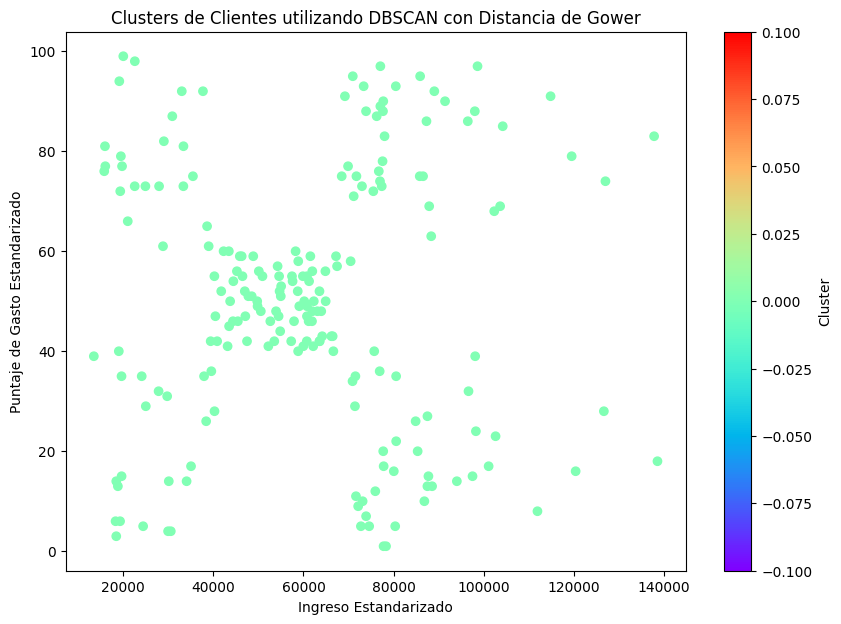

In [105]:
# Implementación de DBSCAN con los parámetros ajustados
eps = 0.5  # Aumenta este valor si encuentras que no hay suficientes clusters o muchos puntos están etiquetados como ruido
min_samples = 5  # Puedes ajustar este valor según la densidad de tus datos

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
dbscan.fit(gower_dist)

# Número de clusters encontrados (excluyendo ruido)
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f"Número de clusters encontrados: {n_clusters}")

# Añadir resultados de clustering al dataframe original
datos['Cluster_DBSCAN'] = dbscan.labels_

# Descripción de los clusters encontrados
for cluster in range(n_clusters):
    cluster_data = datos[datos['Cluster_DBSCAN'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Cantidad de clientes: {len(cluster_data)}")
    print(f"Ingreso promedio: {cluster_data['Ingreso'].mean():.2f}")
    print(f"Puntaje de gasto promedio: {cluster_data['Puntaje_Gasto'].mean():.2f}")
    print(f"Distribución de género: {cluster_data['Genero'].value_counts(normalize=True)}")
    print(f"Distribución de grupo etario: {cluster_data['Grupo_Etario'].value_counts(normalize=True)}")

# Visualización de los clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(datos['Ingreso'], datos['Puntaje_Gasto'], c=datos['Cluster_DBSCAN'], cmap='rainbow', label='Datos Clusterizados')
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters de Clientes utilizando DBSCAN con Distancia de Gower')
plt.xlabel('Ingreso Estandarizado')
plt.ylabel('Puntaje de Gasto Estandarizado')
plt.show()




Incorporar las variables adicionales de Género y Grupo Etario puede mejorar la focalización de la estrategia de marketing, ya que proporciona una visión más completa del comportamiento del cliente. Estos clusters pueden revelar patrones específicos de comportamiento por género y grupo etario, permitiendo campañas de marketing más personalizadas y efectivas. Por ejemplo, ciertos productos o promociones pueden ser más atractivos para un grupo etario o género específico, optimizando así el rendimiento de las estrategias de marketing.